In [47]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.mixture import GaussianMixture as GMM
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import sklearn.cluster as cluster
from sklearn.ensemble import RandomForestClassifier

In [2]:
directory = 'C:/githubrepo/7331_Project/data/'
df_zg = pd.read_csv(directory + 'Diabetic_Cleaned.csv')
print("Done reading data.")

Done reading data.


In [3]:
df_zg_makehot = df_zg[["max_glu_serum", "A1Cresult", "insulin"]]
df_zg_ok = df_zg[["age", "gender", "diabetesMed"]]

In [4]:
#Make age ordinal
for i in range(0, 10):
    val = "[" + str(i*10) + "-" + str((i+1)*10) + ")"
    df_zg_ok.loc[df_zg_ok['age'] == val, 'age'] = i
df_zg_ok["age"] = df_zg_ok["age"].astype(int)
 
#Gender: 1 = Female, 0 = Male
df_zg_ok.gender[df_zg_ok.gender == 'Male'] = 0
df_zg_ok.gender[df_zg_ok.gender == 'Female'] = 1
df_zg_ok["gender"] = df_zg_ok["gender"].astype(object)

#diabetesMed: 1 = Yes, 0 = No
df_zg_ok.diabetesMed[df_zg_ok.diabetesMed == 'No'] = 0
df_zg_ok.diabetesMed[df_zg_ok.diabetesMed == 'Yes'] = 1
df_zg_ok["diabetesMed"] = df_zg_ok["diabetesMed"].astype(object)

In [5]:
df_zg_hot_x = pd.concat([df_zg_ok, pd.get_dummies(df_zg_makehot)], axis = 1)
df_zg_y = df_zg["readmitted_tf"]

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df_zg_hot_x, df_zg_y, test_size = 0.8, random_state = 7)

#Print out the shapes of the train/valid/test sets
x_train.shape, x_test.shape

((20353, 15), (81413, 15))

In [10]:
scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

# ALL Types of Clustering

#### Clustering functions

In [22]:
#https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
#Runs the clusters and returns the scores
def do_clusters(data, algorithm, args, kwds, do_sil = False):
    alg = algorithm(*args, **kwds)
    labels = alg.fit_predict(data)
    
    #dist = kmeans.inertia_
    dbs = (metrics.davies_bouldin_score(data, labels)) #Smaller = Better
    chs = (metrics.calinski_harabasz_score(data, labels)) #Bigger = Better
    ss = 1
    if do_sil:
        ss = (metrics.silhouette_score(data, labels, metric='euclidean')) #Smaller=Better
    
    return [dbs, chs, ss]

#Plots the metrics for the clusters
def plot_metrics(m_df, size_rng, do_sil = True):
    plt.plot(size_rng, m_df.DBS, marker = 'o')
    plt.xlabel('n_components')
    plt.ylabel('Davies Bouldin Score')
    plt.show()
    plt.plot(size_rng, m_df.CHS, marker = 'o')
    plt.xlabel('n_components')
    plt.ylabel('Calinski Harabasz Score')
    plt.show()
    if do_sil:
        plt.plot(size_rng, m_df.SS, marker = 'o')
        plt.xlabel('n_components')
        plt.ylabel('Silhouette Score')
        plt.show()
    #plt.xticks(np.arange(1, 20, 1)) 

## KMeans Clustering

DBS: 9, CHS: 11, SS: ?

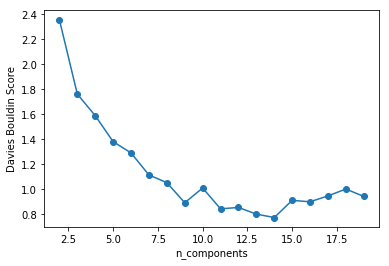

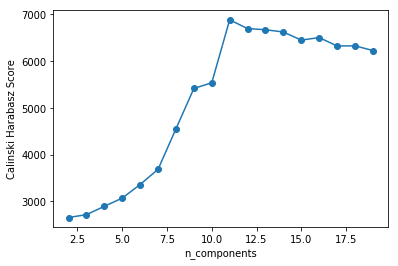

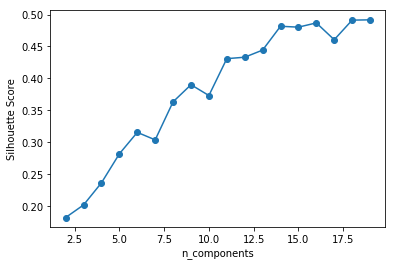

Wall time: 1min 44s


In [17]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS'])
#Range for the number of clusters
size_rng = range(2,20)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.KMeans, (), {'n_clusters':i}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

## KMeans Weighted

DBS: 2-3, CHS: 4, SS: ?

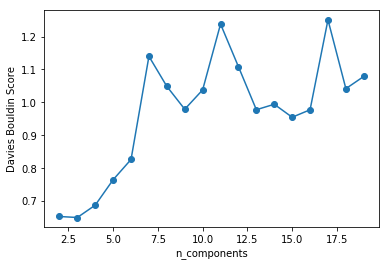

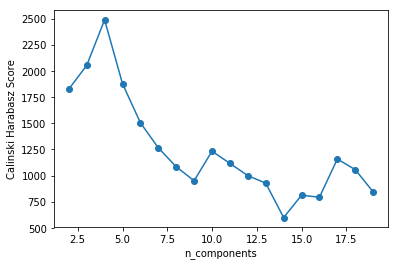

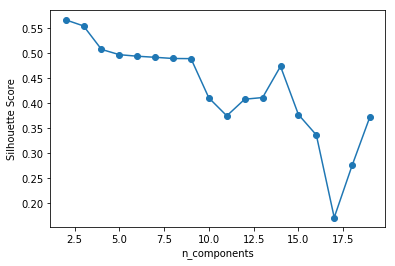

Wall time: 2min


In [29]:
%%time
# calculate distortion for a range of number of cluster
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS'])
sizeRange = range(2, 20)
weight = compute_sample_weight(class_weight='balanced', y = x_train)
for i in sizeRange:
    kmeans = KMeans(n_clusters = i, init = 'random', n_init = 10, n_jobs = -1).fit(x_train, sample_weight = weight)
    labels = kmeans.labels_
    dbs = (metrics.davies_bouldin_score(x_train, labels))
    chs = (metrics.calinski_harabasz_score(x_train, labels))
    ss = (metrics.silhouette_score(x_train, labels, metric='euclidean'))
    metric_df.loc[len(metric_df), :] = [dbs, chs, ss]

plot_metrics(metric_df, sizeRange)

## Agglomerative Clustering

DBS: 10, CHS: 11, SS: ?

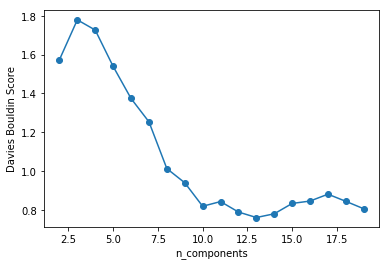

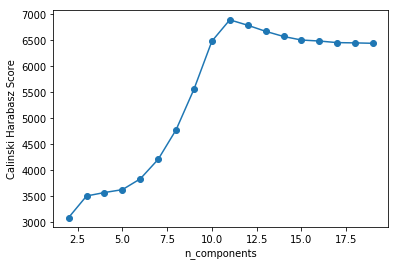

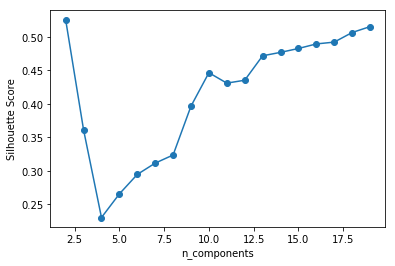

Wall time: 4min 42s


In [43]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS'])
#Range for the number of clusters
size_rng = range(2,20)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.AgglomerativeClustering, (),
                                                   {'n_clusters':i, 'linkage':'ward'}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

## OPTICS

##### 10-70

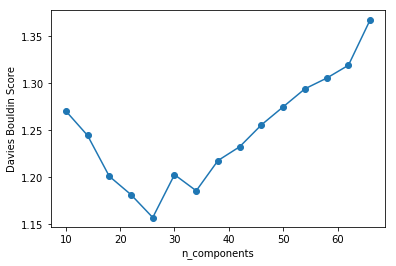

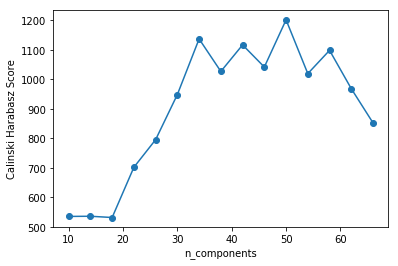

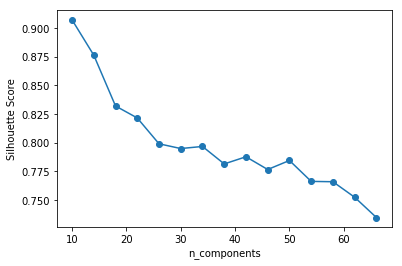

Wall time: 27min 29s


In [42]:
%%time
#Dataframe to hold the metrics
metric_df = pd.DataFrame(columns=['DBS', 'CHS', 'SS'])
#Range for the number of clusters
size_rng = range(10,70,4)

for i in size_rng:
    metric_df.loc[len(metric_df), :] = do_clusters(x_train, cluster.OPTICS, (), {'min_samples':i}, True)

#Plots the metrics
plot_metrics(metric_df, size_rng)

# Check Validity of Cluster with RF

In [44]:
#Function that appends the cluster number to the dataframe
def make_df(df, lbl, names):
    #Make a data frame with the cluster number added onto it
    the_df = pd.concat([pd.DataFrame(df), pd.DataFrame(list(lbl))], axis=1)
    names.append("Clust")
    the_df.columns = names
    the_df["Clust"] = the_df["Clust"].astype(int)
    return the_df

#### KMeans: 9, 11

In [48]:
%%time
kmeans = KMeans(n_clusters = 11, init = 'random', n_init = 10, n_jobs = -1).fit(x_train)

#Make a data frame with the cluster number added onto it
x_train_kmeans = make_df(x_train, kmeans.labels_, list(df_zg_hot_x.columns))

Wall time: 555 ms


In [49]:
%%time

NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000        
        
rf_clf = RandomForestClassifier(random_state = RANDOM_STATE, criterion = 'gini', 
                                n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(x_train_kmeans.loc[:, x_train_kmeans.columns != 'Clust'], x_train_kmeans["Clust"])

preds = rf_clf.predict(x_train_kmeans.loc[:, x_train_kmeans.columns != 'Clust'])
print("Balanced Accuracy", metrics.balanced_accuracy_score(x_train_kmeans["Clust"], preds))

Balanced Accuracy 1.0
Wall time: 453 ms


#### Agglomerative: 10, 11

In [50]:
%%time
agg = AgglomerativeClustering(n_clusters = 11, linkage = 'ward').fit(x_train)

#Make a data frame with the cluster number added onto it
x_train_agg = make_df(x_train, agg.labels_, list(df_zg_hot_x.columns))

Wall time: 8.9 s


In [51]:
%%time

NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000        
        
rf_clf = RandomForestClassifier(random_state = RANDOM_STATE, criterion = 'gini', 
                                n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(x_train_agg.loc[:, x_train_agg.columns != 'Clust'], x_train_agg["Clust"])

preds = rf_clf.predict(x_train_agg.loc[:, x_train_agg.columns != 'Clust'])
print("Balanced Accuracy", metrics.balanced_accuracy_score(x_train_agg["Clust"], preds))

Balanced Accuracy 1.0
Wall time: 450 ms


#### OPTICS: 34

In [52]:
%%time
opt = OPTICS(min_samples = 34).fit(x_train)

#Make a data frame with the cluster number added onto it
x_train_opt = make_df(x_train, opt.labels_, list(df_zg_hot_x.columns))

Wall time: 1min 45s


In [53]:
%%time

NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000        
        
rf_clf = RandomForestClassifier(random_state = RANDOM_STATE, criterion = 'gini', 
                                n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(x_train_opt.loc[:, x_train_opt.columns != 'Clust'], x_train_opt["Clust"])

preds = rf_clf.predict(x_train_opt.loc[:, x_train_opt.columns != 'Clust'])
print("Balanced Accuracy", metrics.balanced_accuracy_score(x_train_opt["Clust"], preds))

Balanced Accuracy 0.9992107860834921
Wall time: 1.89 s


# Cluster Composition

In [72]:
import seaborn as sns
def heat_map(corr):
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True, linewidths = 0.5
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )

## KMeans

#### General Correlation

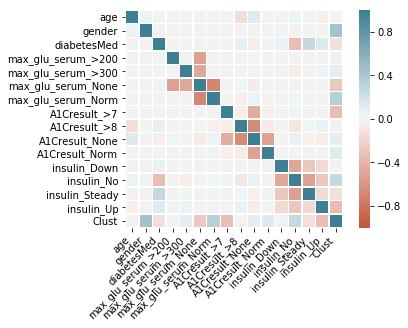

In [84]:
heat_map(x_train_kmeans.corr())

#### In Cluster Correlation

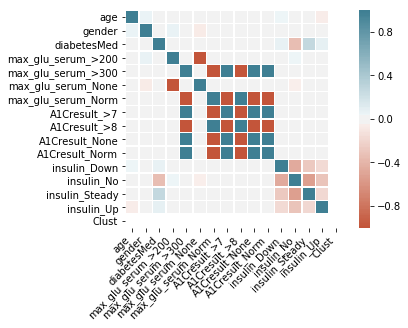

In [73]:
#0 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 0].corr())

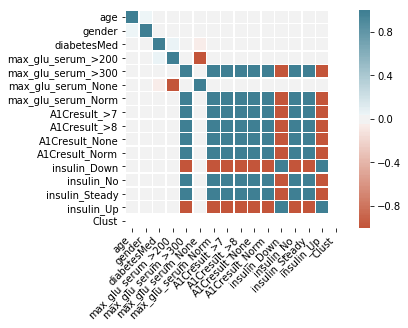

In [74]:
#1 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 1].corr())

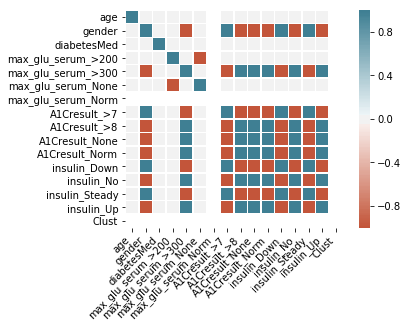

In [83]:
#2 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 2].corr())

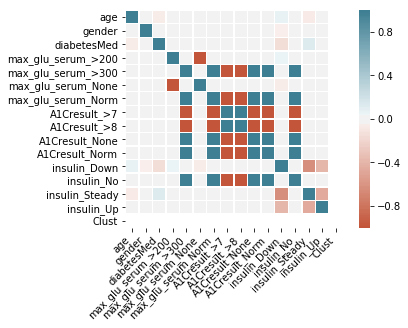

In [82]:
#3 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 3].corr())

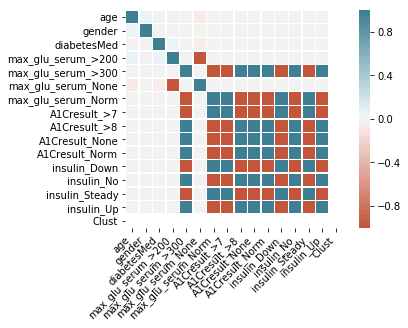

In [81]:
#4 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 4].corr())

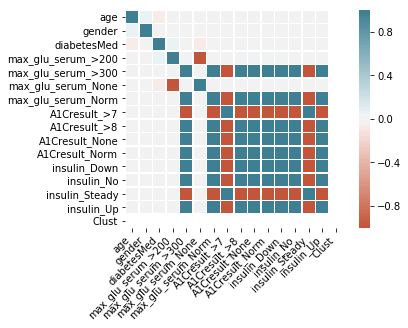

In [80]:
#5 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 5].corr())

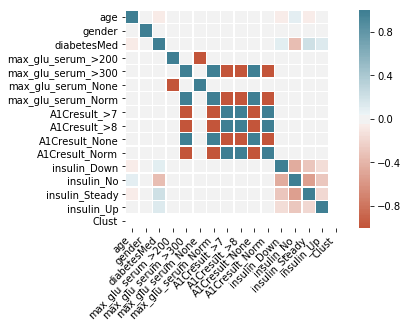

In [79]:
#6 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 6].corr())

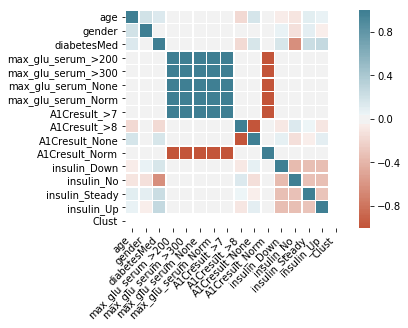

In [78]:
#7 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 7].corr())

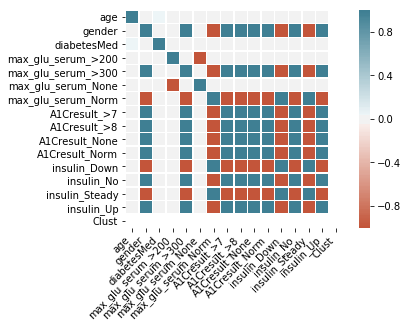

In [77]:
#8 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 8].corr())

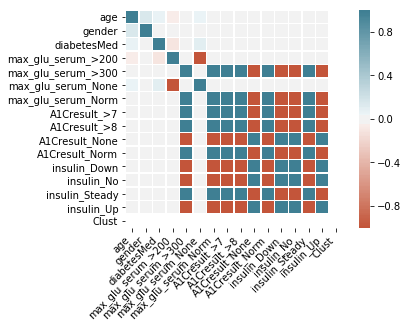

In [76]:
#9 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 9].corr())

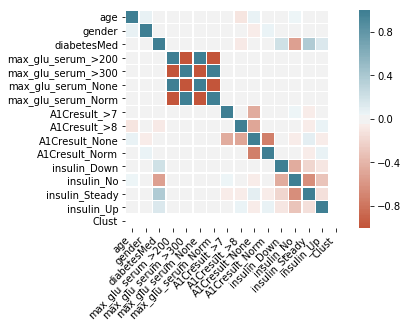

In [75]:
#10 KMeans Heatmap
heat_map(x_train_kmeans[x_train_kmeans["Clust"] == 10].corr())